# Classification ECG either Normal or Abnormal 

### Introduction:

<img src="heartbeat.png" style="width:760px;height:368px;">

This work allows to classify the cardiographic ECG in normal and abnormal and for the abnormal categories also to classify them in under classify in Tachycardias and Bradycardia using LSTM in a first case then try to add the mechanism of attention to be facliser on paying attention to cardiac ECG regions.

I have two different datasets, but I will only consider one at the start: mitbih. The MIT-BIH arrhythmia database contains 48 half-hour extracts from two-channel ambulatory ECG recordings obtained from 47 subjects studied by the BIH arrhythmia laboratory between 1975 and 1979 Twenty-three records were randomly selected from a pool of 4,000 24- hour-long ambulatory ECG records collected from a mixed population of hospitalized (approximately 60%) and ambulatory (approximately 40%) hospital patients. Beth Israel of Boston; the remaining 25 records were selected from the same set to include less common but clinically significant arrhythmias that would not be well represented in a small random sample. souces: https://www.kaggle.com/shayanfazeli/heartbeat


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt # plotting
import os
import sklearn
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import scipy
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout, LSTM, GRU, Bidirectional

Using TensorFlow backend.


### Data loading

In [2]:
test=pd.read_csv("C:/Users/asus/Desktop/DataSet/mitbih_test.csv",header=None) 
train=pd.read_csv("C:/Users/asus/Desktop/DataSet/mitbih_train.csv",header=None) 
#Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
# N- normal, S-supraventricular, V-ventricular, F-fusion, Q- unknown

In [3]:
print("Type\tCount")
print((train[187]).value_counts())

print("train shape : ",train.shape)
print("test shape : ",test.shape)

Type	Count
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64
train shape :  (87554, 188)
test shape :  (21892, 188)


### Processing data

In [4]:
# making multiclass to binary class new labels_train containing either 0 or 1 

label_train=[] 
for i in train.iloc[:,187] :
    if i not in  [0.0]:
        label_train.append(1)
        #print("value is",i)
    else:
        label_train.append(0)
        #print("value",i)

In [5]:
# making multiclass to binary class.now labels_test containing either 0 or 1 

label_test=[]  
for i in test.iloc[:,187]:
    if i not in  [0.0]:
        label_test.append(1)
        #print("value is",i)
    else:
        label_test.append(0)
        #print("value",i)

In [6]:
#create new df 
labels_train = pd.DataFrame({'col':label_train})
#print (labels_train)

labels_test = pd.DataFrame({'col':label_test})
#print (labels_test)

In [7]:
label_train=np.asarray(label_train)

label_test=np.asarray(label_test)

train[187] = labels_train    # replace labels column with binary labels
test[187] =  labels_test

In [8]:
print('Count of all classes in training dataset')
print("Type\tCount")
print((train[187]).value_counts())

print('*************************************')

print('Count of all classes in test dataset')
print("Type\tCount")
print((test[187]).value_counts())

Count of all classes in training dataset
Type	Count
0    72471
1    15083
Name: 187, dtype: int64
*************************************
Count of all classes in test dataset
Type	Count
0    18118
1     3774
Name: 187, dtype: int64


In [9]:
train

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [10]:
dt = np.array(train)
dt_test=np.array(test)

No handles with labels found to put in legend.


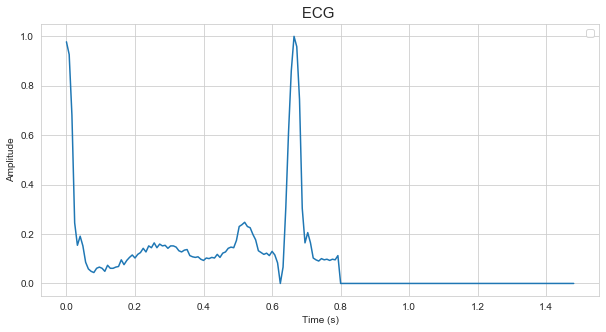

In [11]:
import seaborn as sb
import scipy as sc
import matplotlib.pyplot as plt
sb.set_style("whitegrid")
x = np.arange(0, 186)*0.008 # In the experiment, only ECG lead II, MI and healthy samples were used. And in the experiment, the re-sampling frequency is 125 Hz. That is 0.008s. A signal contains 187 values, which is about 1.5s.
plt.figure(figsize=(10,5))
plt.plot(x, dt[0,:186] ) # data should  be array !

plt.legend()
plt.title("ECG ", fontsize=15)
plt.ylabel("Amplitude", fontsize=10)
plt.xlabel("Time (s)", fontsize=10)
plt.show()

In [12]:
def detect_peaks(data): # data should be array 
    pos=0
    pospeak=[]

    for i in data:
        pos=pos+1
        if i > 0.9 and i < 1:
            pospeak.append(pos)
            #print("peak")
    return ( pospeak)

In [13]:
def calc_bpm(x,pospeak):
    i=len(pospeak)-1
    carreau = x[pospeak[i]]/0.04
    bpm = 1500 / carreau
    return bpm
# This formula from: https://litfl.com/ecg-rate-interpretation/

In [14]:
#add column to my data 
train[188]=1
test[188]=1

## Make train set classified by heart rates 

In [15]:
bpmcoeur=[]
i=0
for e in dt:# extract row by row in my data 
    x = np.arange(0, 188)*0.008
    pospeak=[]
    pospeak=detect_peaks(e)
    #print(pospeak)
    if not pospeak :
        train[188][i]=0
        i=i+1
    else:
        b=calc_bpm(x,pospeak)
        train[188][i]=float(b)
        i=i+1
        bpmcoeur.append(b)
#print(bpmcoeur)

C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [16]:
"""
Normal: 60–100 beats/min + signal normal                    ->  classe 0
Anormal : Heart rates <60 or > 100 + "S" , "V" , "Q" or "F" -> classe 1
"""
data = train
for i in range(len(data)):
    if data[187][i] == 0 :
        # all signaux normal
        if data[188][i] >= 60 and data[188][i] <= 100 :
            data[188][i]=0 # sig have normal heart rates 
        elif data[188][i] < 60 or data[188][i] > 100:
            data[187][i]=1

C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [17]:
train[187].value_counts() # 0 : signal normal , 1 : signal abnormal

1    56725
0    30829
Name: 187, dtype: int64

## Make test set classified by heart rates

In [18]:
bpmcoeur_test=[]
i=0
for e in dt_test:# extract row by row in our data 
    x = np.arange(0, 188)*0.008
    pospeak=[]
    pospeak=detect_peaks(e)
    #print(pospeak)
    if not pospeak :
        test[188][i]=0
        i=i+1
    else:
        b=calc_bpm(x,pospeak)
        test[188][i]=float(b)
        i=i+1
        bpmcoeur_test.append(b)
#print(bpmcoeur_test) 

C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [19]:
data_test = test
for i in range(len(data_test)):
    if data_test[187][i] == 0 :
        # all signaux normal
        if data_test[188][i] >= 60 and data_test[188][i] <= 100 :
            data_test[188][i]=0 # sig have normal heart rates 
        elif data_test[188][i] < 60 or data_test[188][i] > 100:
            data_test[187][i]=1

C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
test[187].value_counts()

1    14138
0     7754
Name: 187, dtype: int64

## Training 

In [21]:
print("train shape : ",train.shape)
print("test shape : ",test.shape)

feature_train=train.iloc[:,0:187] 
#feature_train=train.iloc[:,3] 
print("feature_train shape : ",feature_train.shape)

labels_train=train.iloc[:,187] 
print("labels_train shape : ",labels_train.shape)

feature_test=test.iloc[:,0:187] 
#feature_test=test.iloc[:,3] 
print("feature_test shape : ",feature_test.shape)

labels_test=test.iloc[:,187] 
print("labels_test shape : ",labels_test.shape)

train shape :  (87554, 189)
test shape :  (21892, 189)
feature_train shape :  (87554, 187)
labels_train shape :  (87554,)
feature_test shape :  (21892, 187)
labels_test shape :  (21892,)


In [22]:
from sklearn.preprocessing import StandardScaler
standardized_training_data=StandardScaler().fit_transform(feature_train)
feature_train=standardized_training_data
print(feature_train.shape)

standardized_test_data=StandardScaler().fit_transform(feature_test)
feature_test=standardized_test_data
print(feature_test.shape)

(87554, 187)
(21892, 187)


In [23]:
import numpy as np
from keras.utils import np_utils 
import seaborn as sns
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing import sequence
# fixed random seed for reproducibility
np.random.seed(7)

In [24]:
x_train1=feature_train
x_test1=feature_test
y_train1=labels_train
y_test1=labels_test

In [25]:
x_train1=x_train1.reshape(x_train1.shape[0],1,x_train1.shape[1])
x_test1=x_test1.reshape(x_test1.shape[0],1,x_test1.shape[1])

In [26]:
# here we are having a class number for each sample
print("Class label of first sample:",y_train1[83456])

# lets convert this into a 10 dimensional vector
# ex: consider an image is 5 convert it into 5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

#Y_train = np_utils.to_categorical(label_train, 2) 
#Y_test = np_utils.to_categorical(label_test, 2)

Y_train = np_utils.to_categorical(y_train1)
print("After converting the output into a vector : ",Y_train[83456])

Y_test = np_utils.to_categorical(y_test1)

Class label of first sample: 1
After converting the output into a vector :  [0. 1.]


In [27]:
print("feature_train",x_train1.shape)
print("Y_train",Y_train.shape)
print("feature_test",x_test1.shape)
print("Y_test",Y_test.shape)

feature_train (87554, 1, 187)
Y_train (87554, 2)
feature_test (21892, 1, 187)
Y_test (21892, 2)


In [28]:
output_dim = 2
input_dim = feature_train.shape[1]

batch_size = 512
nb_epoch = 100

model_lstm =Sequential()
model_lstm.add(LSTM(125))
model_lstm.add(Dropout(rate = 0.25))
model_lstm.add(Dense(output_dim, input_dim=input_dim, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [29]:
history = model_lstm.fit(x_train1, Y_train,validation_data=(x_test1,Y_test), epochs=100,batch_size=512)

Train on 87554 samples, validate on 21892 samples
Epoch 1/100
87554/87554 [==============================] - 4s 40us/step - loss: 0.4352 - accuracy: 0.7588 - val_loss: 0.3818 - val_accuracy: 0.7891
Epoch 2/100
87554/87554 [==============================] - 2s 23us/step - loss: 0.3734 - accuracy: 0.7971 - val_loss: 0.3569 - val_accuracy: 0.8078
Epoch 3/100
87554/87554 [==============================] - 2s 23us/step - loss: 0.3544 - accuracy: 0.8129 - val_loss: 0.3514 - val_accuracy: 0.8179
Epoch 4/100
87554/87554 [==============================] - 2s 23us/step - loss: 0.3494 - accuracy: 0.8174 - val_loss: 0.3374 - val_accuracy: 0.8252
Epoch 5/100
87554/87554 [==============================] - 2s 23us/step - loss: 0.3339 - accuracy: 0.8311 - val_loss: 0.3246 - val_accuracy: 0.8388
Epoch 6/100
87554/87554 [==============================] - 2s 23us/step - loss: 0.3245 - accuracy: 0.8384 - val_loss: 0.3191 - val_accuracy: 0.8438
Epoch 7/100
87554/87554 [==============================] - 2s 

Epoch 56/100
87554/87554 [==============================] - 2s 23us/step - loss: 0.2345 - accuracy: 0.8960 - val_loss: 0.2675 - val_accuracy: 0.8794
Epoch 57/100
87554/87554 [==============================] - 2s 24us/step - loss: 0.2442 - accuracy: 0.8905 - val_loss: 0.2638 - val_accuracy: 0.8807
Epoch 58/100
87554/87554 [==============================] - 2s 23us/step - loss: 0.2544 - accuracy: 0.8842 - val_loss: 0.2846 - val_accuracy: 0.8626
Epoch 59/100
87554/87554 [==============================] - 2s 23us/step - loss: 0.2788 - accuracy: 0.8714 - val_loss: 0.2617 - val_accuracy: 0.8843
Epoch 60/100
87554/87554 [==============================] - 2s 24us/step - loss: 0.2470 - accuracy: 0.8885 - val_loss: 0.2585 - val_accuracy: 0.8854
Epoch 61/100
87554/87554 [==============================] - 2s 23us/step - loss: 0.2466 - accuracy: 0.8886 - val_loss: 0.2582 - val_accuracy: 0.8851
Epoch 62/100
87554/87554 [==============================] - 2s 23us/step - loss: 0.2474 - accuracy: 0.8875

In [30]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 125)               156500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 252       
Total params: 156,752
Trainable params: 156,752
Non-trainable params: 0
_________________________________________________________________


In [31]:
predictions=model_lstm.predict(x_test1)

In [32]:
print(classification_report(Y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      7754
           1       0.91      0.91      0.91     14138

    accuracy                           0.88     21892
   macro avg       0.87      0.87      0.87     21892
weighted avg       0.88      0.88      0.88     21892



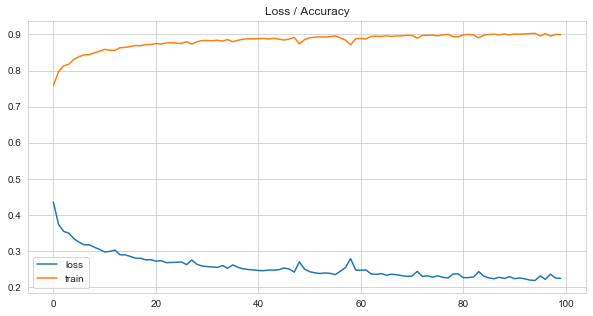

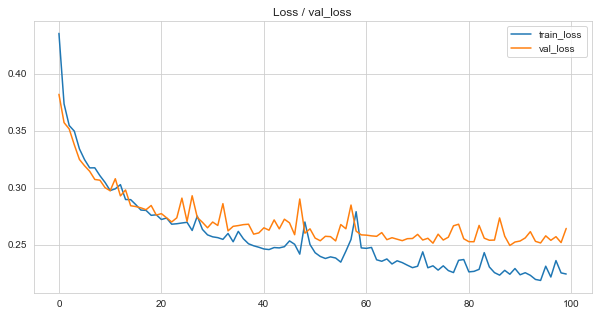

In [33]:
plt.figure(figsize=(10,5))
plt.title('Loss / Accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title('Loss / val_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Classification ECG either Tachycardia or Bradycardia

In [34]:
#Anormal : Heart rates <60 or > 100 + "S" , "V" , "Q" or "F" -> classe 1

train[188].value_counts()

0       44358
7500    12127
3750     7982
110       764
108       731
        ...  
357         2
441         1
340         1
535         1
416         1
Name: 188, Length: 131, dtype: int64

In [35]:
for i in range(len(data)):
    if data[187][i] != 0 :
        # all signaux abnormal I classifie to class 0 ,1 or 2
        if data[188][i] < 60 :
            data[188][i]=1
        elif data[188][i] < 100:
            data[188][i]=0
        else :
            data[188][i]=2
    else :
        #all signaux normal it's classifie to normal beats 
        data[188][i]=0 

C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ""

In [36]:
data[188].value_counts()

0    36494
2    32332
1    18728
Name: 188, dtype: int64

In [37]:
from sklearn.utils import resample

df11 =data[data[188]==1]
df22=data[data[188]==2] 
df_1_upsample=resample(df11,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df22,replace=True,n_samples=20000,random_state=124)
train_df=pd.concat([df_1_upsample,df_2_upsample])

In [38]:
equilibre=train_df[188].value_counts()
print(equilibre)

2    20000
1    20000
Name: 188, dtype: int64


In [39]:
data

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,188
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


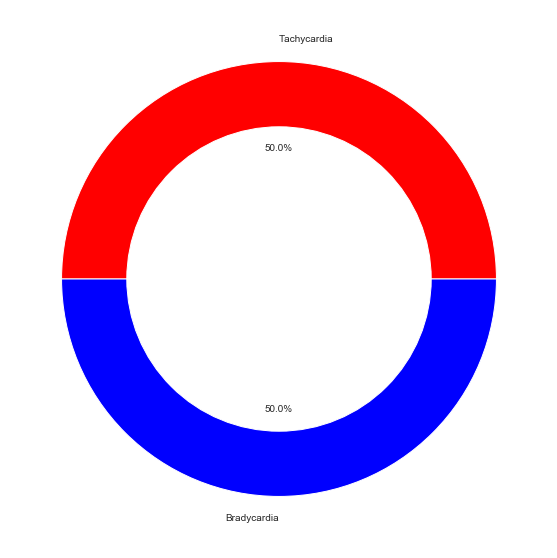

In [40]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['Tachycardia','Bradycardia'], colors=['red','blue'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [41]:
df_train1, df_test1 = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df[188])

In [42]:
print("train shape : ",df_train1.shape)
print("test shape : ",df_test1.shape)

feature_train1=df_train1.iloc[:,0:187] 
#feature_train=train.iloc[:,3] 
print("feature_train shape : ",feature_train1.shape)

labels_train1=df_train1.iloc[:,188] 
print("labels_train shape : ",labels_train1.shape)

feature_test1=df_test1.iloc[:,0:187] 
#feature_test=test.iloc[:,3] 
print("feature_test shape : ",feature_test1.shape)

labels_test1=df_test1.iloc[:,188] 
print("labels_test shape : ",labels_test1.shape)

train shape :  (32000, 189)
test shape :  (8000, 189)
feature_train shape :  (32000, 187)
labels_train shape :  (32000,)
feature_test shape :  (8000, 187)
labels_test shape :  (8000,)


In [43]:
from sklearn.preprocessing import StandardScaler
standardized_training_data=StandardScaler().fit_transform(feature_train1)
feature_train1=standardized_training_data
print(feature_train1.shape)

standardized_test_data=StandardScaler().fit_transform(feature_test1)
feature_test1=standardized_test_data
print(feature_test1.shape)

(32000, 187)
(8000, 187)


In [44]:
x_train2=feature_train1
x_test2=feature_test1
y_train2=labels_train1
y_test2=labels_test1

In [45]:
print(x_train2.shape,y_train2.shape)

(32000, 187) (32000,)


In [46]:
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
target_train=df_train1[188]
target_test=df_test1[188]
Y_train2=to_categorical(target_train)
Y_test2=to_categorical(target_test)
print(Y_train2.shape,Y_test2.shape)

(32000, 3) (8000, 3)


In [47]:
df_train1[188].value_counts()

2    16000
1    16000
Name: 188, dtype: int64

## Create BiLSTM model 


 I'm using the embedding layer  for taking just the abnormal signals  and classify them as signals bradycardia or tachycardia

In [49]:
MAX_SEQUENCE_LENGTH = 187
EMBEDDING_DIM = 186
VALIDATION_SPLIT = 0.2

output_dim = 3
input_dim = feature_train.shape[1]
embedding_matrix = np.random.random((len(df_train1),EMBEDDING_DIM)) 
x1 =df_train1[df_train1[187]!= 0]
for i in range(len(x1)):
    embedding_matrix[i]=x1.iloc[i,:186]

In [51]:
model = Sequential()
model.add(Embedding(len(df_train1),
                    186,
                    weights = [embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable = True))
model.add(Bidirectional(LSTM(125)))
model.add(Dense(output_dim, input_dim=input_dim, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 187, 186)          5952000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250)               312000    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 753       
Total params: 6,264,753
Trainable params: 6,264,753
Non-trainable params: 0
_________________________________________________________________


In [52]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("model fitting - Bidirectional LSTM")
print("----------The fitting process is ignored here.")
hist=model.fit(x_train2, Y_train2, 
          validation_data=(x_test2,Y_test2),
          epochs=10,batch_size=512)

Num GPUs Available:  1
model fitting - Bidirectional LSTM
----------The fitting process is ignored here.


C:\Users\asus\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 63s 2ms/step - loss: 0.4591 - accuracy: 0.7026 - val_loss: 0.4334 - val_accuracy: 0.7213
Epoch 2/10
32000/32000 [==============================] - 61s 2ms/step - loss: 0.4239 - accuracy: 0.7426 - val_loss: 0.4088 - val_accuracy: 0.7753
Epoch 3/10
32000/32000 [==============================] - 61s 2ms/step - loss: 0.3996 - accuracy: 0.7734 - val_loss: 0.3872 - val_accuracy: 0.7874
Epoch 4/10
32000/32000 [==============================] - 62s 2ms/step - loss: 0.3869 - accuracy: 0.7899 - val_loss: 0.3748 - val_accuracy: 0.8176
Epoch 5/10
32000/32000 [==============================] - 62s 2ms/step - loss: 0.3540 - accuracy: 0.8257 - val_loss: 0.3378 - val_accuracy: 0.8382
Epoch 6/10
32000/32000 [==============================] - 62s 2ms/step - loss: 0.3388 - accuracy: 0.8356 - val_loss: 0.3319 - val_accuracy: 0.8427
Epoch 7/10
32000/32000 [==============================] - 62s 2ms/ste

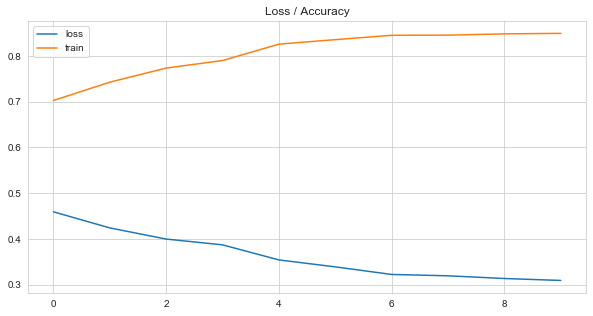

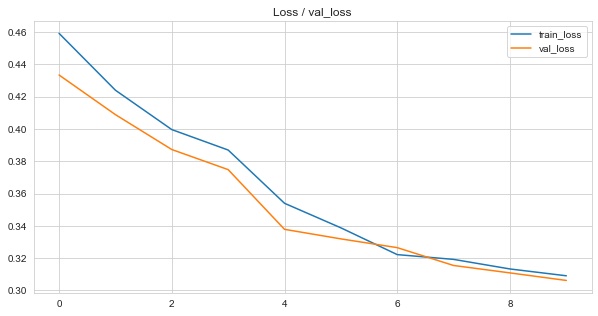

In [54]:
plt.figure(figsize=(10,5))
plt.title('Loss / Accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['accuracy'], label='train')
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title('Loss / val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [58]:
pred_test = model.predict(x_test2) 
pred_test = (pred_test>0.5).astype(np.int8)

In [55]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
acc = accuracy_score(Y_test2, pred_test)
print("Test accuracy score : %s "% acc)

Test accuracy score : 0.769375 


In [56]:
pred_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]], dtype=int8)

In [57]:
Y_test2

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)


<br> Realized by : <i> Bouifalioune Hind </i> 
<br> Email : Hd.bouifalioune@gmail.com